In [7]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
import numpy as np
import pandas as pd
import os
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
import utilities
from descriptor import rdkitDescriptors

In [12]:
df=pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))

In [13]:
df.shape

(1063, 124)

* clean out-of-bound value

In [14]:
df['cleaned_bod'] =utilities.clean_out_of_bound(df['value (% BOD)'])

## 0. Calculate all features from rdkitDescriptors, from SMILES

In [15]:
features = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'])

## 1. bi-class assignment by hard cutoff(0.6)

In [6]:
df['bod_class'] = utilities.bi_class(df['cleaned_bod'], 0.6)

Plot the histogram distribution of degradable and non degradable.  
The graph shows it is kind of even

(array([419.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 644.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

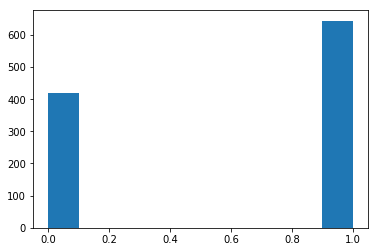

In [8]:
plt.hist(df['bod_class'])

In [9]:
features.columns

Index(['exactmw', 'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD',
       'NumHBA', 'NumHeteroatoms', 'NumAmideBonds', 'FractionCSP3', 'NumRings',
       ...
       'MQN33', 'MQN34', 'MQN35', 'MQN36', 'MQN37', 'MQN38', 'MQN39', 'MQN40',
       'MQN41', 'MQN42'],
      dtype='object', length=139)

* Store SMILES, true BOD label, new generated features into a new dataframe `bod_feature`

In [11]:
bod_feature=pd.concat([df['SMILES'],df['bod_class'],features], axis=1)

In [20]:
bod_feature.shape

(1063, 141)

In [22]:
#bod_feature.to_csv(os.path.join(DATA_PATH,'BOD_biclass_139rdkit.csv'),index=False) #save combined feature to file

bod_feature.describe()

### 1.1 Divide the columns by dtypes (float and int)

Only 'SMILES' as object, 97 cols as float64, 43 cols int64

In [13]:
bod_feature.get_dtype_counts()

float64    97
int64      43
object      1
dtype: int64

#### 1.1.1 int features and histogram, to check for distributions for each variable  
try eliminate variables that has single value

In [14]:
feat_int = bod_feature.select_dtypes(include=['int64'])

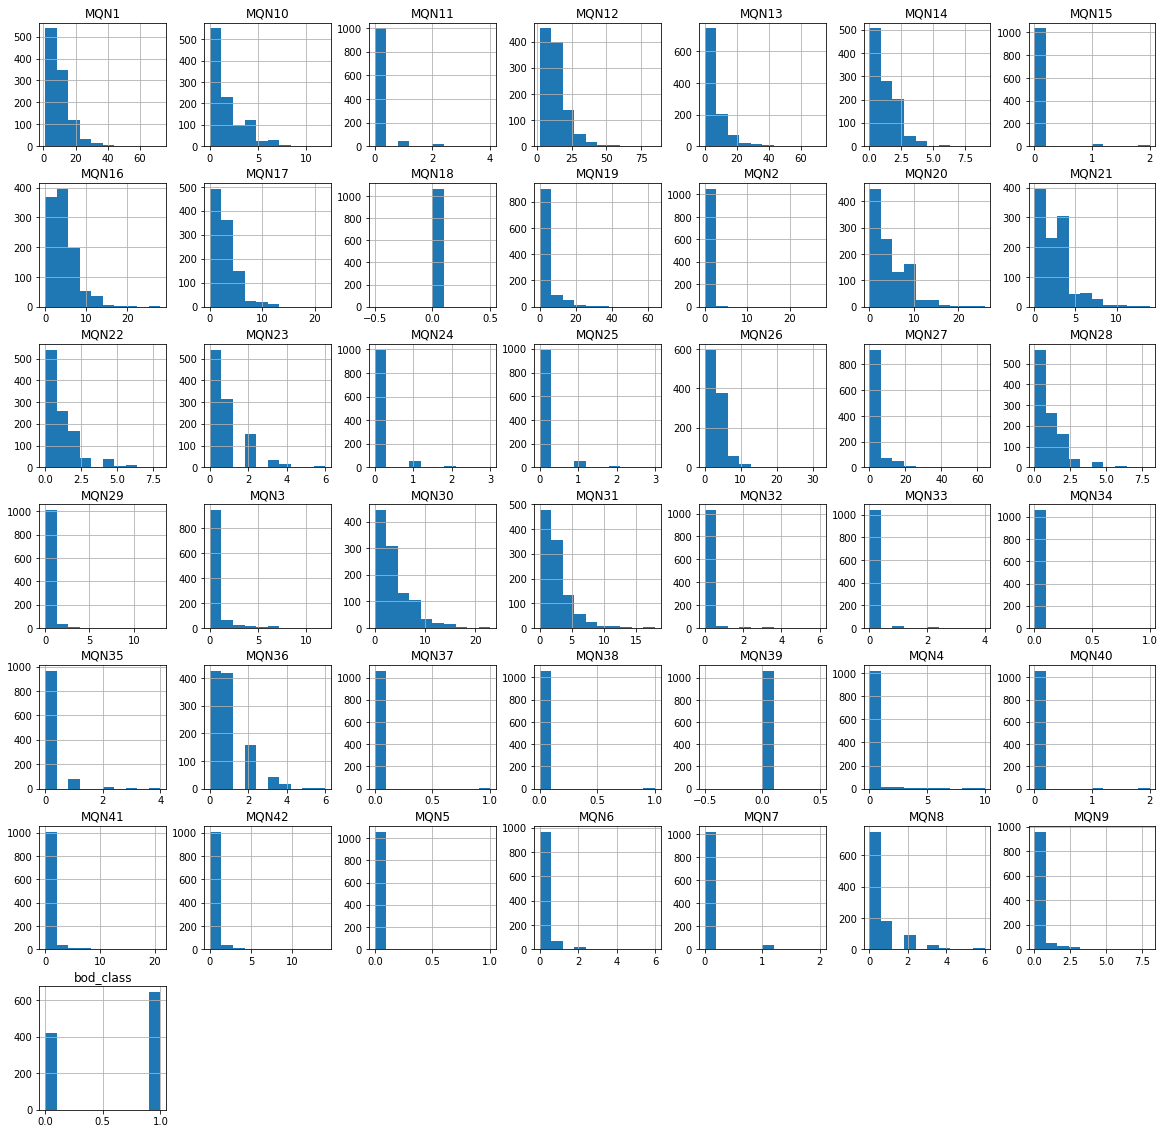

In [16]:
hist=feat_int.hist(figsize=(20,20))

Only keep the columns where the values are not identical  (shrinked two dimension)

In [17]:
selected_int_feat = feat_int.loc[:,feat_int.nunique()>1]

In [18]:
bod_int_feat = pd.concat([bod_feature[['SMILES','bod_class']],selected_int_feat],axis=1)

#### 1.1.2 float features and histogram, to check for distributions for each variable  
try eliminate variables that has single value

In [19]:
feat_float = bod_feature.select_dtypes(include=['float64'])

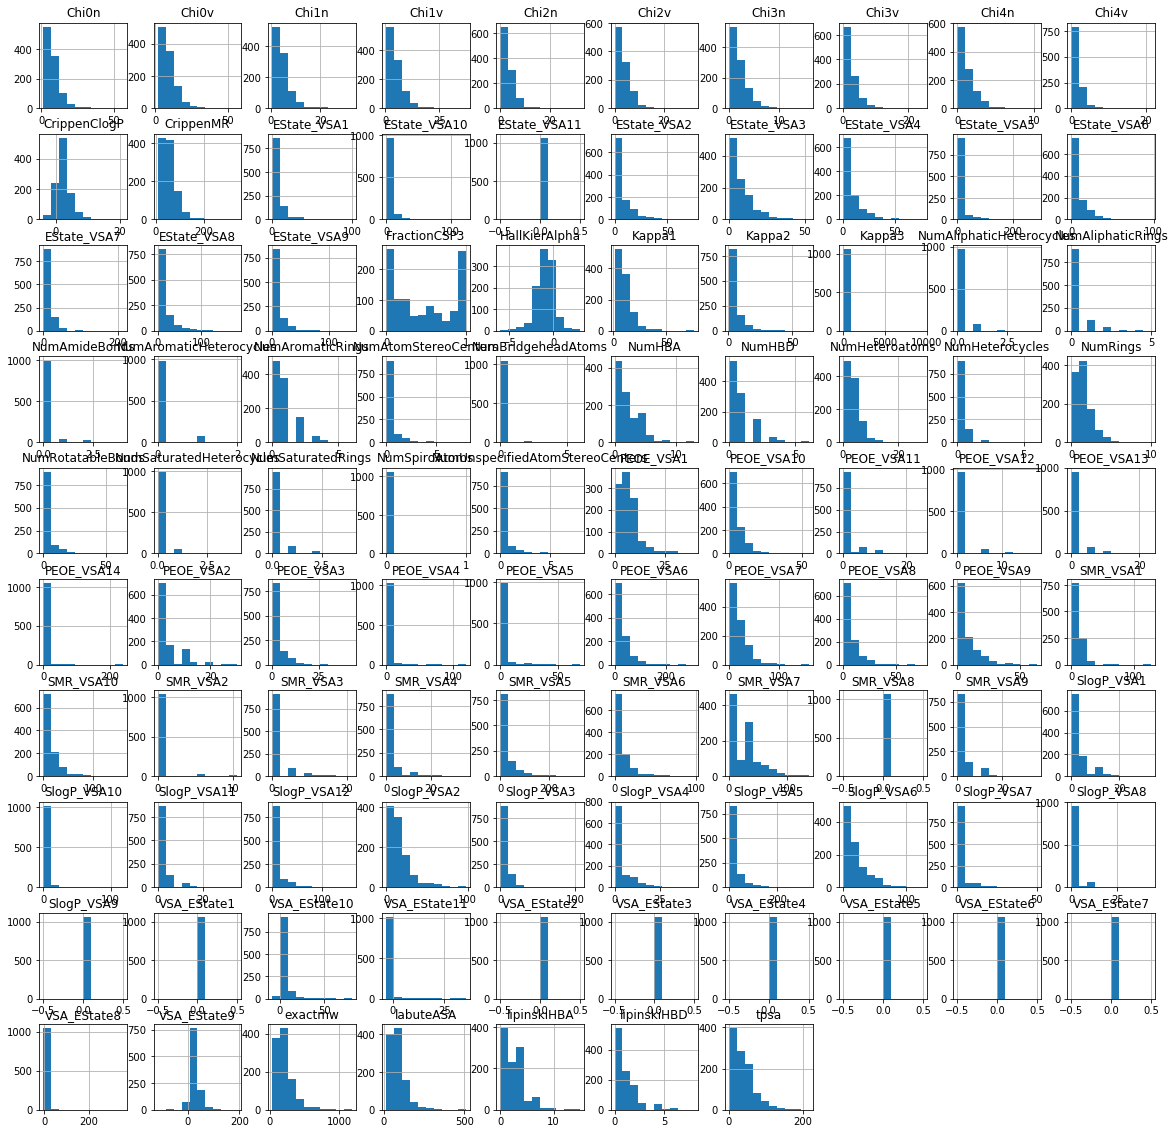

In [106]:
hist2=feat_float.hist(figsize=(20,20))

In [107]:
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]

In [113]:
selected_float_feat.shape

(1063, 87)

Dropped 10 cols

In [108]:
bod_float_feat = pd.concat([bod_feature[['SMILES','bod_class']],selected_float_feat],axis=1)

### 1.2 Baseline k-means clustering

In [115]:
from sklearn.cluster import KMeans
import sklearn.metrics.cluster as cluster_metric

### 1.2.1 int features 

In [118]:
kmeans_int = KMeans(n_clusters=2, init='k-means++', tol=1e-6).fit(selected_int_feat.values)

#### 1.2.1.1 metrics assuming not base on true label

In [121]:
int_labels=kmeans_int.labels_

* Silhouette Coefficient

In [123]:
cluster_metric.silhouette_score(selected_int_feat.values, int_labels, metric='euclidean')

0.5471748003900353

* calinski_harabaz_score(X, labels) 

In [124]:
cluster_metric.calinski_harabaz_score(selected_int_feat.values, int_labels) 

674.4480052239014

* davies_bouldin_score(X, labels)

In [125]:
cluster_metric.davies_bouldin_score(selected_int_feat.values, int_labels)

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


1.0113958000770928

#### 1.2.1.2 metrics with ground true label

In [126]:
true_label = bod_feature['bod_class'].values

* Adjusted Rand index (regardless of real label, only calculate purity!!)

In [130]:
cluster_metric.adjusted_rand_score(true_label, int_labels) ## a bad score is close to 0 or negative

-0.01338626441591872

* Mutual Information based scores

In [131]:
cluster_metric.adjusted_mutual_info_score(true_label, int_labels) 

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.0035136398338304017

* Homogeneity, completeness and V-measure

In [133]:
cluster_metric.homogeneity_completeness_v_measure(true_label, int_labels) ## really bad

(0.004214986774487867, 0.006621724875113914, 0.005151098169882209)

* Fowlkes-Mallows scores

In [134]:
cluster_metric.fowlkes_mallows_score(true_label, int_labels)  ###???

0.6168114149194187

### 1.2.2. float features 


In [135]:
kmeans_float = KMeans(n_clusters=2, init='k-means++', tol=1e-6).fit(selected_float_feat.values)

In [136]:
flt_labels=kmeans_float.labels_

In [138]:
np.unique(flt_labels)

array([0, 1])

#### 1.2.2.1 metrics assuming not base on true label

In [139]:
cluster_metric.silhouette_score(selected_float_feat.values, flt_labels, metric='euclidean')

0.9772412798979195

In [140]:
cluster_metric.calinski_harabaz_score(selected_float_feat.values, flt_labels) 

2449.94638482056

In [141]:
cluster_metric.davies_bouldin_score(selected_float_feat.values, flt_labels) ###???

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


0.015276316032467912

* float features Shows better cluster performance compare to the int features

#### 1.2.2.2 metrics with ground true label

In [142]:
cluster_metric.adjusted_rand_score(true_label, flt_labels) ## a bad score is close to 0 or negative

0.001010160055991552

In [143]:
cluster_metric.adjusted_mutual_info_score(true_label, flt_labels) 

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.0003660130893609191

In [144]:
cluster_metric.homogeneity_completeness_v_measure(true_label, flt_labels)

(0.0013070628252264953, 0.11692504973110492, 0.0025852263405759875)

In [145]:
cluster_metric.fowlkes_mallows_score(true_label, flt_labels)  ###???

0.7221166159562245

### 1.2.3. attempt to combine float and int features (remove identical input)

In [146]:
joint_feat = pd.concat([selected_int_feat,selected_float_feat], axis=1)

In [156]:
kmeans_comb = KMeans(n_clusters=2, init='k-means++', tol=1e-6).fit(joint_feat.values)

In [157]:
comb_label=kmeans_comb.labels_

* use only accuracy for this case

In [158]:
cluster_metric.adjusted_rand_score(true_label, comb_label) ## a bad score is close to 0 or negative

0.001010160055991552

In [159]:
cluster_metric.adjusted_mutual_info_score(true_label, comb_label)

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.0003660130893609191

In [160]:
cluster_metric.homogeneity_completeness_v_measure(true_label, comb_label)

(0.0013070628252264953, 0.11692504973110492, 0.0025852263405759875)

In [161]:
cluster_metric.fowlkes_mallows_score(true_label, comb_label)

0.7221166159562245

## 2. bi-class by 50% quantile

In [52]:
df['bi_class_q50']=pd.qcut(df['cleaned_bod'].values, 2, labels=[0,1])

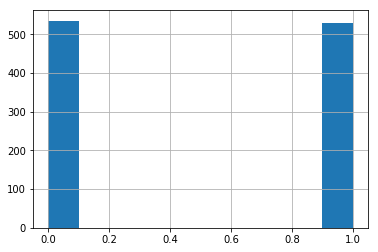

In [55]:
df['bi_class_q50'].hist() #50/50

In [56]:
features = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'])
bod_feature=pd.concat([df['SMILES'],df['bi_class_q50'],features], axis=1)

In [57]:
feat_int = bod_feature.select_dtypes(include=['int64'])
selected_int_feat = feat_int.loc[:,feat_int.nunique()>1]

In [58]:
feat_float = bod_feature.select_dtypes(include=['float64'])
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]

### 2.1 Kmeans by 50% quantile

In [60]:
from sklearn.cluster import KMeans
import sklearn.metrics.cluster as cluster_metric

In [67]:
true_label = bod_feature['bi_class_q50'].values

In [61]:
kmeans_int = KMeans(n_clusters=2, init='k-means++', tol=1e-6).fit(selected_int_feat.values)

In [63]:
int_labels=kmeans_int.labels_

#### 2.1.1 metrics without ground true label (int model)

In [64]:
cluster_metric.silhouette_score(selected_int_feat.values, int_labels, metric='euclidean')

0.5475756430178326

In [65]:
cluster_metric.calinski_harabaz_score(selected_int_feat.values, int_labels) 

675.2304536098828

In [66]:
cluster_metric.davies_bouldin_score(selected_int_feat.values, int_labels)

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


1.0107598758571776

#### 2.1.2. metrics with ground true label (int model)

In [68]:
cluster_metric.adjusted_rand_score(true_label, int_labels) ## a bad score is close to 0 or negative

0.001795278078604992

In [69]:
cluster_metric.adjusted_mutual_info_score(true_label, int_labels) 

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.001956553743866271

In [70]:
cluster_metric.homogeneity_completeness_v_measure(true_label, int_labels) 

(0.002636005876416948, 0.004280409317187768, 0.0032627260792584697)

In [71]:
cluster_metric.fowlkes_mallows_score(true_label, int_labels)  ###???

0.6093197129654911

* not much difference than the hard cutoff (0.6) classes

#### 2.1.3 metrics without ground true label (float model)

In [73]:
kmeans_float = KMeans(n_clusters=2, init='k-means++', tol=1e-6).fit(selected_float_feat.values)

In [74]:
flt_labels=kmeans_float.labels_

In [75]:
cluster_metric.silhouette_score(selected_float_feat.values, flt_labels, metric='euclidean')

0.9772412798979195

In [76]:
cluster_metric.calinski_harabaz_score(selected_float_feat.values, flt_labels) 

2449.94638482056

In [77]:
cluster_metric.davies_bouldin_score(selected_float_feat.values, flt_labels) ###???

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


0.015276316032467912

In [78]:
cluster_metric.adjusted_rand_score(true_label, flt_labels) ## a bad score is close to 0 or negative

-2.4617415490710395e-05

#### 2.1.4 metrics with ground true label (float model)

In [80]:
cluster_metric.adjusted_mutual_info_score(true_label, flt_labels) 

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


-8.895584308100804e-06

In [81]:
cluster_metric.homogeneity_completeness_v_measure(true_label, flt_labels)

(0.0009324855614722467, 0.08622182815151025, 0.0018450173355687419)

In [82]:
cluster_metric.fowlkes_mallows_score(true_label, flt_labels)  ###???

0.7061152060370829

### Plot the distribution of BOD, it is difficult to divide into more than 3 classes by quantile

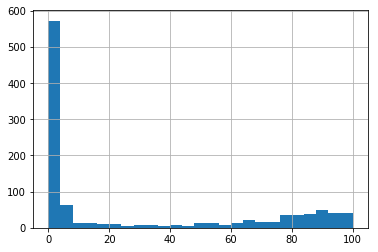

In [85]:
df['cleaned_bod'].hist(bins=25)

In [29]:
sum(df['cleaned_bod'] ==0)

413

* 413 cases bod=0

* the bod is highly skewed and it's difficult to break into quantiles while keeping count in each group even

### Three classes

In [117]:
tri_cuts=df['cleaned_bod'].quantile([0.33,0.66])

In [91]:
pd.qcut(df['cleaned_bod'].values, 3, labels=[0,1,2],duplicates='drop') #can not use default function

ValueError: Bin labels must be one fewer than the number of bin edges

#### Only use float to cluster

In [127]:
features = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'])
bod_feature=pd.concat([df['SMILES'],df['tri_class_q33'],features], axis=1)
feat_float = bod_feature.select_dtypes(include=['float64'])
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]

In [129]:
true_label = bod_feature['tri_class_q33'].values

In [131]:
kmeans_float = KMeans(n_clusters=3, init='k-means++', tol=1e-6).fit(selected_float_feat.values)
flt_labels=kmeans_float.labels_